In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

yf.pdr_override()

In [11]:
#get data from yahoo
df = pdr.get_data_yahoo("TSLA", start = "2019-11-24", end = "2020-12-18")

df['HighS'] = df['High'].shift(1)
df['LowS'] = df['Low'].shift(1)
df['CloseS'] = df['Close'].shift(1)
print(df.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-12-11  615.010010  624.000000  596.799988  609.989990  609.989990   
2020-12-14  619.000000  642.750000  610.200012  639.830017  639.830017   
2020-12-15  643.280029  646.900024  623.799988  633.250000  633.250000   
2020-12-16  628.229980  632.500000  605.000000  622.770020  622.770020   
2020-12-17  628.190002  658.820007  619.500000  655.900024  655.900024   

              Volume       HighS        LowS      CloseS  
Date                                                      
2020-12-11  46475000  627.750000  566.340027  627.070007  
2020-12-14  52040600  624.000000  596.799988  609.989990  
2020-12-15  45223600  642.750000  610.200012  639.830017  
2020-12-16  42095800  646.900024  623.799988  633.250000  
2020-12-17  56270100  632.500000  605.000000  622.770020  

In [12]:
openLong = []
openShort = []

In [13]:
shortDate = []
shortValue = []
longDate = []
longValue = []
closeLongDate = []
closeLongValue = []
closeShortDate = []
closeShortValue = []

In [14]:
#Variables for printable data/value
total = 0
win = 0
lose = 0
profit = 0

In [15]:
#index variable
n = 0

In [16]:
period = 14
#Average True Range
data = df.copy()
high = data['High']
low = data['Low']
close = data['Close']
data['tr0'] = abs(high - low)
data['tr1'] = abs(high - close.shift())
data['tr2'] = abs(low - close.shift())
df['TR'] = data[['tr0', 'tr1', 'tr2']].max(axis = 1)
df['ATR'] = df['TR'].ewm(span = period).mean()

df['up'] = df['High'] - df['HighS']
df['down'] = df['LowS'] - df['Low']

#Directional Movement DM+
df['DM+'] = np.where((df['up'] > df['down'])&(df['up'] > 0), df['up'], 0)
df['DM-'] = np.where((df['down'] > df['up'])&(df['down'] > 0), df['down'], 0)

#Directional Index
df['DI+'] = ((df['DM+'] / df['ATR']).ewm(span = period).mean())*100
df['DI-'] = ((df['DM-'] / df['ATR']).ewm(span = period).mean())*100

df['rownum'] = np.arange(len(df))
#Directional Movement Index
df['DX'] = np.where(df['rownum']<period*2, 20, (abs((df['DI+'] - df['DI-'])/(df['DI+']+df['DI-']))*100).ewm(span = period).mean())

In [17]:
#loop for test strategy
for val in df['DI+']:
    #condition for long position
    if val > df['DI-'][n]:
        longValue.append(df['Close'][n])
        longDate.append(df['Close'].index[n])
        #remember long position
        openLong.append(df['Close'][n])
    #condition for short position
    if val < df['DI-'][n]:
        shortValue.append(df['Close'][n])
        shortDate.append(df['Close'].index[n])
        #remember short position
        openShort.append(df['Close'][n])
    #condition for closing long position
    if len(openLong) > 0 and val < df['DI-'][n]:
        closeLongDate.append(df['Close'].index[n])
        closeLongValue.append(df['Close'][n])
        
        #subtract closing price from all open long positions stored in a list
        openLong = [df['Close'][n] - x for x in openLong]
        profit += sum(openLong)
        
        #total long trade, win long trades, loss long trades
        total += len(openLong)
        win += len([i for i in openLong if i >= 0])
        lose += len([i for i in openLong if i < 0])
        
        #empty open long trades
        openLong = []
    
    #condition for closing short position
    if len(openShort)>0 and val < df['DI+'][n]:
        closeShortDate.append(df['Close'].index[n])
        closeShortValue.append(df['Close'][n])
        
        #subtracting closing price from all open short positions in a list
        openShort = [x-data['Close'][n] for x in openShort]
        profit += sum(openShort)
        
        #total short trades, won short trades, loss short trades
        total += len(openShort)
        win += len([i for i in openShort if i >= 0])
        lose += len([i for i in openShort if i < 0])
        
        #empty open short trades
        openShort = []
        
    #index increase
    n += 1

In [18]:
#print summary statistics
print(f"Total amount of orders executed: {total}")
print(f"Number of wins: {win}")
print(f"Number of losses: {lose}")
if total != 0:
    print(("Hitrate:", (win/total)*100, "%"))
print(f"Net profit: {profit}")

Total amount of orders executed: 177
Number of wins: 94
Number of losses: 83
('Hitrate:', 53.10734463276836, '%')
Net profit: -128.27022552490234


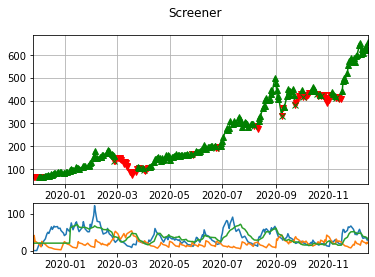

<Figure size 1512x144 with 0 Axes>

In [19]:
#plot graphs and markers

#plot graph
fig, axs = plt.subplots(2, gridspec_kw = {'height_ratios': [3, 1]})
fig.suptitle('Screener')
plt.figure(figsize = (21,2))

#Main graph window
axs[0].plot(df['Close'], color = "g")
axs[0].grid()
axs[0].set_xlim([df['Close'].index[0], df['Close'].index[len(df['Close'])-1]])

#short position markers
axs[0].plot(shortDate, shortValue, 'rv')

#long position markers
axs[0].plot(longDate, longValue, 'g^')

#close long position
axs[0].plot(closeLongDate, closeLongValue, 'gx')

#close short position
axs[0].plot(closeShortDate, closeShortValue, 'rx')

#DMI
axs[1].plot(df['DI+'])
axs[1].plot(df['DI-'])
axs[1].plot(df['DX'])
axs[1].set_xlim([data['Close'].index[0], data['Close'].index[len(data['Close'])-1]])
plt.show()